<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>EDA & Preprocessing
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Vorgegebenes Ziel

Wir evaluieren 3 verschiedene Klassifikationssysteme in einer Textklassifikationsaufgabe. <br><br>
Wir argumentieren, warum wir diese Systeme für diesen Fall ausgewählt haben, und bauen, trainieren und bewerten das System. <br><br>
Wir führen auch eine gründliche Fehleranalyse durch und schlagen Theorien zur Verbesserung der Systeme vor, <br>
insbesondere durch die Analyse einzelner Fälle und den Vergleich der Vorhersagen jedes Systems. <br>
Mindestens eines der Systeme basiert auf einem feinabgestimmten Deep-Learning-Modell.

Hier können wir Daten aus gemeinsamen Aufgaben verwenden, wie zum Beispiel Semeval, Kaggle, <br>Codalab oder Paperwithcode für die Textklassifikation.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
PyTorch Version: 2.0.1+cpu
Numpy Version: 1.26.0
Pandas Version: 2.1.1
Matplotlib Version: 3.8.0
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.

## Gewählter Datensatz

Wir haben uns für den <a href="https://www.kaggle.com/competitions/nlp-getting-started/data">"Natural Language Processing with Disaster Tweets"</a> Datensatz entschieden.<br><br>
Der Datensatz passt zum Ziel der Mini Challenge, da er Textdaten aus Twitter enthält, die in Notfällen <br>als wichtiger Kommunikationskanal dienen. Dies ermöglicht die Entwicklung und Evaluierung von <br>Textklassifikationssystemen, um Tweets zu identifizieren, die echte Katastrophen ankündigen, <br>von solchen, die dies nicht tun. <br><br>Dies erfordert eine gründliche Fehleranalyse und die Entwicklung von Modellen, die in der Lage sind, <br>die Bedeutung von Wörtern und Ausdrücken im Kontext zu verstehen, da Tweets oft metaphorische <br>Sprache verwenden können. <br><br>Wir haben Zugriff auf einen Datensatz von 10.000 handklassifizierten Tweets, der eine solide <br>Grundlage für die Evaluierung und Verbesserung von Textklassifikationssystemen bietet.

## Explorative Datenanalyse

In [19]:
tweets = pd.read_csv("./data/train.csv", index_col="id", encoding="utf-8")
tweets.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

Der Datensatz hat zum Text und dem Target noch die Spalten Keyword und Location. Diese werden wir für die Klassifikation nicht verwenden. Ein hybrides Modell könnte die Vorhersage verbessern.

In [20]:
tweets = tweets.loc[:,["text","target"]]

Damit wir keinen Leak von Trainingsdaten in die Testdaten haben müssen wir den Datensatz auf Duplikate überprüfen und allfällige Duplikate entfernen.

In [21]:
print(f"Anzahl doppelte Werte: {tweets['text'].duplicated().sum()}")

Anzahl doppelte Werte: 110


Wir entfernen alle Duplikate und fügen nur die hinzu, welche sich beim Target einig sind.

In [34]:

unique_tweets, duplicates = (
    tweets.drop_duplicates(subset=["text"], keep=False),
    tweets[tweets["text"].duplicated(keep=False)] \
        .groupby(["text", "target"]).size().reset_index().rename(columns={0: "count"})
)

contradicting_duplicates, agreeing_duplicates = (
    duplicates[duplicates["text"].duplicated(keep=False)],
    duplicates[~duplicates["text"].duplicated(keep=False)]
)
tweets = pd.concat([unique_tweets, agreeing_duplicates.drop_duplicates(subset=["text"])]).loc[:, ["text", "target"]]

Im nächsten Schritt wird ein Trainings- und Testset erstellt. Dies wird zu diesem Zeitpunkt gemacht, damit wir keine Informationen über das Testset gewinnen.

In [35]:
train, test = train_test_split(tweets, test_size=0.2,random_state=10)

Im nächsten Schritt wird untersucht, ob es unbekannte oder doppelte Werte hat. 

In [36]:
print(f"Anzahl NA Werte: {train.isna().any().sum()}")
print(f"Anzahl doppelte Werte: {train['text'].duplicated().sum()}")

Anzahl NA Werte: 0
Anzahl doppelte Werte: 0


Es hat keine NA Werte und logischerweise auch keine doppelte Werte mehr.

Als Target sind die Erwarteten Werte vorhanden.

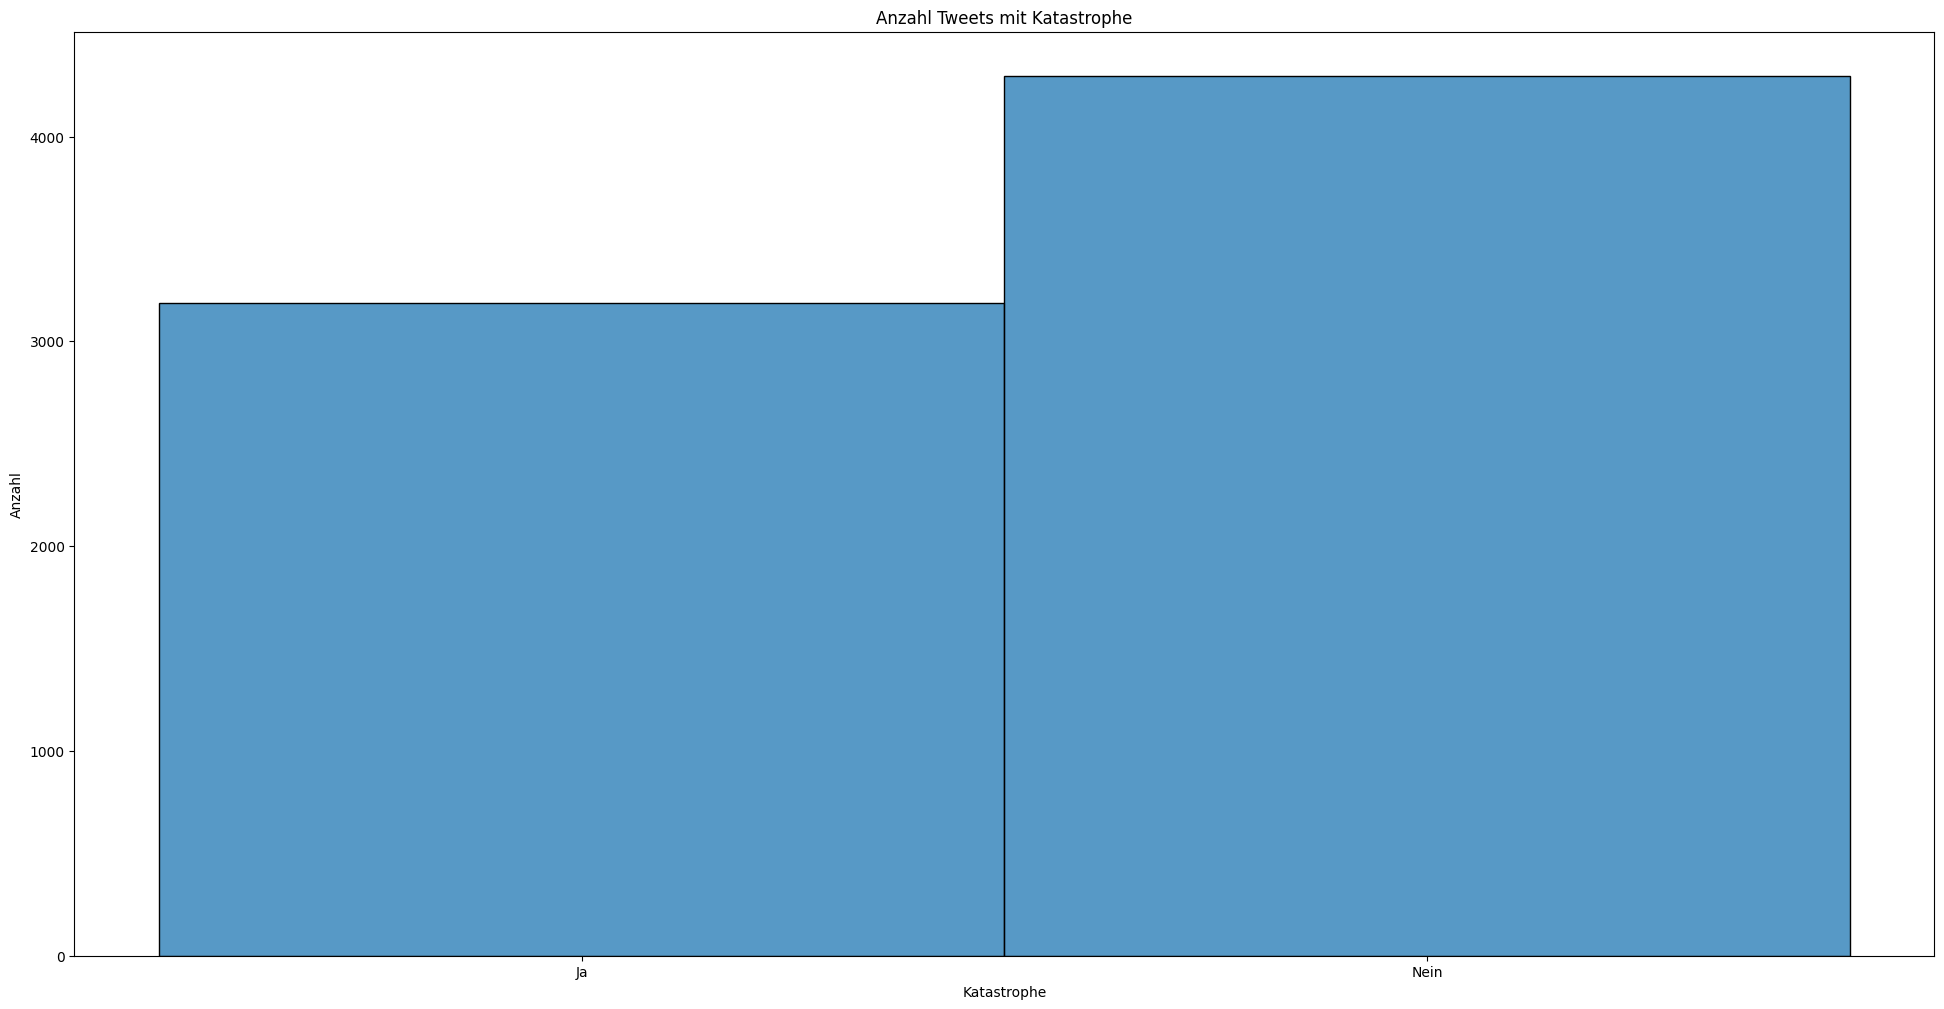

In [37]:
sns.histplot(tweets["target"].replace({0:"Nein",1:"Ja"}))
plt.title("Anzahl Tweets mit Katastrophe")
plt.ylabel("Anzahl")
plt.xlabel("Katastrophe")
plt.show()

Es hat nicht gleiche viele Tweets von beiden Klassen. Dies hat einen Einfluss auf die Metrik, die ausgewählt wird.

### TF-IDF (TODO)

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla euismod, nisl eget aliquam ultricies, nunc nisl ultricies nunc, eget aliq

## Data Preprocessing